# 프로젝트: ResNet Ablation Study

## 평가 루브릭

아래의 기준을 바탕으로 프로젝트를 평가합니다.

평가문항	상세기준
1. ResNet-34, ResNet-50 모델 구현이 정상적으로 진행되었는가? : 블록함수 구현이 제대로 진행되었으며 구현한 모델의 summary가 예상된 형태로 출력되었다.
2. 구현한 ResNet 모델을 활용하여 Image Classification 모델 훈련이 가능한가? : cats_vs_dogs 데이터셋으로 학습시 몇 epoch동안 안정적으로 loss 감소가 진행 확인되었다.
3. Ablation Study 결과가 바른 포맷으로 제출되었는가? : ResNet-34, ResNet-50 각각 plain모델과 residual모델을 동일한 epoch만큼 학습시켰을 때의 validation accuracy 기준으로 Ablation Study 결과표가 작성되었다.



## Cats & Dogs 데이터 세트 가져오기

In [69]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")

In [70]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [71]:
import urllib3#, clipnorm=1.),
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_valid, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=[
        'train[:80%]',
        'train[80%:90%]',
        'train[90%:]'
    ],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

## Cats & Dogs 데이터 확인하기

In [72]:
# 데이터의 개수도 확인하기 
ds_train_len=tf.data.experimental.cardinality(ds_train)
ds_valid_len=tf.data.experimental.cardinality(ds_valid)
ds_test_len=tf.data.experimental.cardinality(ds_test)
print(ds_train_len)
print(ds_valid_len)
print(ds_test_len)

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(2326, shape=(), dtype=int64)
tf.Tensor(2326, shape=(), dtype=int64)


In [73]:
ds_info

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    version=4.0.0,
    description='A large set of images of cats and dogs.There are 1738 corrupted images that are dropped.',
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=23262,
    splits={
        'train': 23262,
    },
    supervised_keys=('image', 'label'),
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
    title = {Asirra: A CAPTCHA that Exploits Interest-Aligned Manual Image Categorization},
    booktitle = {Proceedings of 14th ACM Conference on Computer and Communications Security (CCS)},
    ye

In [74]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [75]:
ds_info.features["label"].num_classes

2

In [76]:
ds_info.features["label"].names

['cat', 'dog']

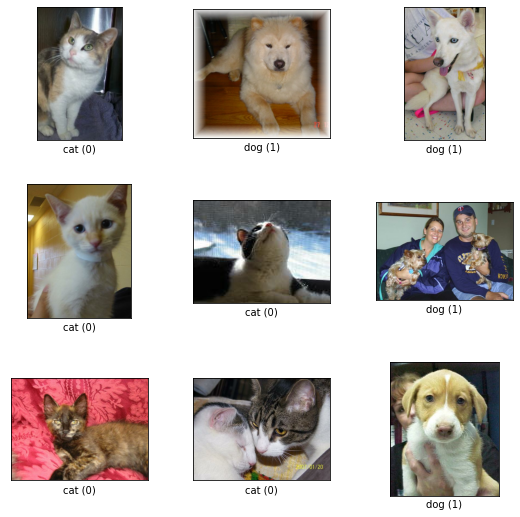

In [65]:
fig = tfds.show_examples(ds_train, ds_info)

## Cats & Dogs 데이터 전처리하기

In [77]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [78]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    return ds

In [79]:
ds_train = apply_normalize_on_dataset(ds_train, is_test=False, batch_size=16)

In [80]:
ds_valid = apply_normalize_on_dataset(ds_valid, is_test=False, batch_size=16)


## 1) ResNet 기본 블록 구성하기
이제 실전으로 돌아와서 ResNet-34와 ResNet-50 네트워크를 직접 만든다고 생각해봅시다. 우선 ResNet-34와 ResNet-50에서 사용되는 블록의 공통점을 찾고 차이점을 찾아봅시다.

![ResNet](Resnet_Architecture.png)

- ResNet논문에 소개된 위 표에서, ResNet 34와 50에서 사용된 블록들의 공통점과 차이점을 비교해보고 그 특징을 정리해봅시다.
    - ResNet-34와 ResNet-50은 모두 conv block이라고 불리는 블록 구조를 각각 3, 4, 6, 3개씩 반복해서 쌓은 형태라는 공통점을 가지고 있습니다. 
    - 그러나 ResNet-34와 ResNet-50의 블록 내부 구성은 약간 다릅니다. ResNet-34의 경우 Block은 3x3 kernel인 Convolution layer로만 구성되어있지만, ResNet-50은 1x1 Convolution이 앞뒤로 붙어 더 많은 레이어를 한 블록 내에 가지게 됩니다.

# 2) ResNet-34, ResNet-50 Complete Model
## (1) ResNet-34
VGG와 같이 블록을 만드는 함수를 사용해서 직접 전체 모델을 만들어 봅시다. ResNet-34와 ResNet-50의 차이에 따라 달라지는 구성(configuration)을 함수에 전달해서 같은 생성 함수 build_resnet()를 통해서 ResNet의 여러가지 버전들을 모두 만들어 낼 수 있도록 해야 합니다.

다음의 코드를 실행하면,

 ~~~ 

resnet_34 = build_resnet(input_shape=(32, 32,3), is_50=False)
resnet_34.summary()

 ~~~ 


아래의 결과가 나와야 한다. 

 ~~~ 

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
==================================================================================================
input_layer (InputLayer)        [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 16, 16, 64)   9472        input_layer[0][0]                
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 16, 16, 64)   256         conv2d_12[0][0]                  
__________________________________________________________________________________________________
activation_351 (Activation)     (None, 16, 16, 64)   0           batch_normalization_12[0][0]     
__________________________________________________________________________________________________
stage2_0_maxpooling (MaxPooling (None, 8, 8, 64)     0           activation_351[0][0]             
__________________________________________________________________________________________________
stage2_1_conv1 (Conv2D)         (None, 8, 8, 64)     36928       stage2_0_maxpooling[0][0]        
__________________________________________________________________________________________________
stage2_1_bn1 (BatchNormalizatio (None, 8, 8, 64)     256         stage2_1_conv1[0][0]             
__________________________________________________________________________________________________
activation_352 (Activation)     (None, 8, 8, 64)     0           stage2_1_bn1[0][0]               
__________________________________________________________________________________________________
stage2_1_conv2 (Conv2D)         (None, 8, 8, 64)     36928       activation_352[0][0]             
__________________________________________________________________________________________________
stage2_1_bn2 (BatchNormalizatio (None, 8, 8, 64)     256         stage2_1_conv2[0][0]             
__________________________________________________________________________________________________
stage2_1_short (Conv2D)         (None, 8, 8, 64)     4160        stage2_0_maxpooling[0][0]        
__________________________________________________________________________________________________
activation_353 (Activation)     (None, 8, 8, 64)     0           stage2_1_bn2[0][0]               
__________________________________________________________________________________________________
stage2_1_bn4 (BatchNormalizatio (None, 8, 8, 64)     256         stage2_1_short[0][0]             
__________________________________________________________________________________________________
stage2_1_add (Add)              (None, 8, 8, 64)     0           activation_353[0][0]             
                                                                 stage2_1_bn4[0][0]               
__________________________________________________________________________________________________
activation_354 (Activation)     (None, 8, 8, 64)     0           stage2_1_add[0][0]               
__________________________________________________________________________________________________
stage2_2_conv1 (Conv2D)         (None, 8, 8, 64)     36928       activation_354[0][0]             
__________________________________________________________________________________________________
stage2_2_bn1 (BatchNormalizatio (None, 8, 8, 64)     256         stage2_2_conv1[0][0]             
__________________________________________________________________________________________________
activation_355 (Activation)     (None, 8, 8, 64)     0           stage2_2_bn1[0][0]               
__________________________________________________________________________________________________
stage2_2_conv2 (Conv2D)         (None, 8, 8, 64)     36928       activation_355[0][0]             
__________________________________________________________________________________________________
stage2_2_bn2 (BatchNormalizatio (None, 8, 8, 64)     256         stage2_2_conv2[0][0]             
__________________________________________________________________________________________________
activation_356 (Activation)     (None, 8, 8, 64)     0           stage2_2_bn2[0][0]               
__________________________________________________________________________________________________
stage2_2_add (Add)              (None, 8, 8, 64)     0           activation_356[0][0]             
                                                                 activation_354[0][0]             
__________________________________________________________________________________________________
activation_357 (Activation)     (None, 8, 8, 64)     0           stage2_2_add[0][0]               
__________________________________________________________________________________________________
stage2_3_conv1 (Conv2D)         (None, 8, 8, 64)     36928       activation_357[0][0]             
__________________________________________________________________________________________________
stage2_3_bn1 (BatchNormalizatio (None, 8, 8, 64)     256         stage2_3_conv1[0][0]             
__________________________________________________________________________________________________
activation_358 (Activation)     (None, 8, 8, 64)     0           stage2_3_bn1[0][0]               
__________________________________________________________________________________________________
stage2_3_conv2 (Conv2D)         (None, 8, 8, 64)     36928       activation_358[0][0]             
__________________________________________________________________________________________________
stage2_3_bn2 (BatchNormalizatio (None, 8, 8, 64)     256         stage2_3_conv2[0][0]             
__________________________________________________________________________________________________
activation_359 (Activation)     (None, 8, 8, 64)     0           stage2_3_bn2[0][0]               
__________________________________________________________________________________________________
stage2_3_add (Add)              (None, 8, 8, 64)     0           activation_359[0][0]             
                                                                 activation_357[0][0]             
__________________________________________________________________________________________________
activation_360 (Activation)     (None, 8, 8, 64)     0           stage2_3_add[0][0]               
__________________________________________________________________________________________________
stage3_1_conv1 (Conv2D)         (None, 4, 4, 128)    73856       activation_360[0][0]             
__________________________________________________________________________________________________
stage3_1_bn1 (BatchNormalizatio (None, 4, 4, 128)    512         stage3_1_conv1[0][0]             
__________________________________________________________________________________________________
activation_361 (Activation)     (None, 4, 4, 128)    0           stage3_1_bn1[0][0]               
__________________________________________________________________________________________________
stage3_1_conv2 (Conv2D)         (None, 4, 4, 128)    147584      activation_361[0][0]             
__________________________________________________________________________________________________
stage3_1_bn2 (BatchNormalizatio (None, 4, 4, 128)    512         stage3_1_conv2[0][0]             
__________________________________________________________________________________________________
stage3_1_short (Conv2D)         (None, 4, 4, 128)    8320        activation_360[0][0]             
__________________________________________________________________________________________________
activation_362 (Activation)     (None, 4, 4, 128)    0           stage3_1_bn2[0][0]               
__________________________________________________________________________________________________
stage3_1_bn4 (BatchNormalizatio (None, 4, 4, 128)    512         stage3_1_short[0][0]             
__________________________________________________________________________________________________
stage3_1_add (Add)              (None, 4, 4, 128)    0           activation_362[0][0]             
                                                                 stage3_1_bn4[0][0]               
__________________________________________________________________________________________________
activation_363 (Activation)     (None, 4, 4, 128)    0           stage3_1_add[0][0]               
__________________________________________________________________________________________________
stage3_2_conv1 (Conv2D)         (None, 4, 4, 128)    147584      activation_363[0][0]             
__________________________________________________________________________________________________
stage3_2_bn1 (BatchNormalizatio (None, 4, 4, 128)    512         stage3_2_conv1[0][0]             
__________________________________________________________________________________________________
activation_364 (Activation)     (None, 4, 4, 128)    0           stage3_2_bn1[0][0]               
__________________________________________________________________________________________________
stage3_2_conv2 (Conv2D)         (None, 4, 4, 128)    147584      activation_364[0][0]             
__________________________________________________________________________________________________
stage3_2_bn2 (BatchNormalizatio (None, 4, 4, 128)    512         stage3_2_conv2[0][0]             
__________________________________________________________________________________________________
activation_365 (Activation)     (None, 4, 4, 128)    0           stage3_2_bn2[0][0]               
__________________________________________________________________________________________________
stage3_2_add (Add)              (None, 4, 4, 128)    0           activation_365[0][0]             
                                                                 activation_363[0][0]             
__________________________________________________________________________________________________
activation_366 (Activation)     (None, 4, 4, 128)    0           stage3_2_add[0][0]               
__________________________________________________________________________________________________
stage3_3_conv1 (Conv2D)         (None, 4, 4, 128)    147584      activation_366[0][0]             
__________________________________________________________________________________________________
stage3_3_bn1 (BatchNormalizatio (None, 4, 4, 128)    512         stage3_3_conv1[0][0]             
__________________________________________________________________________________________________
activation_367 (Activation)     (None, 4, 4, 128)    0           stage3_3_bn1[0][0]               
__________________________________________________________________________________________________
stage3_3_conv2 (Conv2D)         (None, 4, 4, 128)    147584      activation_367[0][0]             
__________________________________________________________________________________________________
stage3_3_bn2 (BatchNormalizatio (None, 4, 4, 128)    512         stage3_3_conv2[0][0]             
__________________________________________________________________________________________________
activation_368 (Activation)     (None, 4, 4, 128)    0           stage3_3_bn2[0][0]               
__________________________________________________________________________________________________
stage3_3_add (Add)              (None, 4, 4, 128)    0           activation_368[0][0]             
                                                                 activation_366[0][0]             
__________________________________________________________________________________________________
activation_369 (Activation)     (None, 4, 4, 128)    0           stage3_3_add[0][0]               
__________________________________________________________________________________________________
stage3_4_conv1 (Conv2D)         (None, 4, 4, 128)    147584      activation_369[0][0]             
__________________________________________________________________________________________________
stage3_4_bn1 (BatchNormalizatio (None, 4, 4, 128)    512         stage3_4_conv1[0][0]             
__________________________________________________________________________________________________
activation_370 (Activation)     (None, 4, 4, 128)    0           stage3_4_bn1[0][0]               
__________________________________________________________________________________________________
stage3_4_conv2 (Conv2D)         (None, 4, 4, 128)    147584      activation_370[0][0]             
__________________________________________________________________________________________________
stage3_4_bn2 (BatchNormalizatio (None, 4, 4, 128)    512         stage3_4_conv2[0][0]             
__________________________________________________________________________________________________
activation_371 (Activation)     (None, 4, 4, 128)    0           stage3_4_bn2[0][0]               
__________________________________________________________________________________________________
stage3_4_add (Add)              (None, 4, 4, 128)    0           activation_371[0][0]             
                                                                 activation_369[0][0]             
__________________________________________________________________________________________________
activation_372 (Activation)     (None, 4, 4, 128)    0           stage3_4_add[0][0]               
__________________________________________________________________________________________________
stage4_1_conv1 (Conv2D)         (None, 2, 2, 256)    295168      activation_372[0][0]             
__________________________________________________________________________________________________
stage4_1_bn1 (BatchNormalizatio (None, 2, 2, 256)    1024        stage4_1_conv1[0][0]             
__________________________________________________________________________________________________
activation_373 (Activation)     (None, 2, 2, 256)    0           stage4_1_bn1[0][0]               
__________________________________________________________________________________________________
stage4_1_conv2 (Conv2D)         (None, 2, 2, 256)    590080      activation_373[0][0]             
__________________________________________________________________________________________________
stage4_1_bn2 (BatchNormalizatio (None, 2, 2, 256)    1024        stage4_1_conv2[0][0]             
__________________________________________________________________________________________________
stage4_1_short (Conv2D)         (None, 2, 2, 256)    33024       activation_372[0][0]             
__________________________________________________________________________________________________
activation_374 (Activation)     (None, 2, 2, 256)    0           stage4_1_bn2[0][0]               
__________________________________________________________________________________________________
stage4_1_bn4 (BatchNormalizatio (None, 2, 2, 256)    1024        stage4_1_short[0][0]             
__________________________________________________________________________________________________
stage4_1_add (Add)              (None, 2, 2, 256)    0           activation_374[0][0]             
                                                                 stage4_1_bn4[0][0]               
__________________________________________________________________________________________________
activation_375 (Activation)     (None, 2, 2, 256)    0           stage4_1_add[0][0]               
__________________________________________________________________________________________________
stage4_2_conv1 (Conv2D)         (None, 2, 2, 256)    590080      activation_375[0][0]             
__________________________________________________________________________________________________
stage4_2_bn1 (BatchNormalizatio (None, 2, 2, 256)    1024        stage4_2_conv1[0][0]             
__________________________________________________________________________________________________
activation_376 (Activation)     (None, 2, 2, 256)    0           stage4_2_bn1[0][0]               
__________________________________________________________________________________________________
stage4_2_conv2 (Conv2D)         (None, 2, 2, 256)    590080      activation_376[0][0]             
__________________________________________________________________________________________________
stage4_2_bn2 (BatchNormalizatio (None, 2, 2, 256)    1024        stage4_2_conv2[0][0]             
__________________________________________________________________________________________________
activation_377 (Activation)     (None, 2, 2, 256)    0           stage4_2_bn2[0][0]               
__________________________________________________________________________________________________
stage4_2_add (Add)              (None, 2, 2, 256)    0           activation_377[0][0]             
                                                                 activation_375[0][0]             
__________________________________________________________________________________________________
activation_378 (Activation)     (None, 2, 2, 256)    0           stage4_2_add[0][0]               
__________________________________________________________________________________________________
stage4_3_conv1 (Conv2D)         (None, 2, 2, 256)    590080      activation_378[0][0]             
__________________________________________________________________________________________________
stage4_3_bn1 (BatchNormalizatio (None, 2, 2, 256)    1024        stage4_3_conv1[0][0]             
__________________________________________________________________________________________________
activation_379 (Activation)     (None, 2, 2, 256)    0           stage4_3_bn1[0][0]               
__________________________________________________________________________________________________
stage4_3_conv2 (Conv2D)         (None, 2, 2, 256)    590080      activation_379[0][0]             
__________________________________________________________________________________________________
stage4_3_bn2 (BatchNormalizatio (None, 2, 2, 256)    1024        stage4_3_conv2[0][0]             
__________________________________________________________________________________________________
activation_380 (Activation)     (None, 2, 2, 256)    0           stage4_3_bn2[0][0]               
__________________________________________________________________________________________________
stage4_3_add (Add)              (None, 2, 2, 256)    0           activation_380[0][0]             
                                                                 activation_378[0][0]             
__________________________________________________________________________________________________
activation_381 (Activation)     (None, 2, 2, 256)    0           stage4_3_add[0][0]               
__________________________________________________________________________________________________
stage4_4_conv1 (Conv2D)         (None, 2, 2, 256)    590080      activation_381[0][0]             
__________________________________________________________________________________________________
stage4_4_bn1 (BatchNormalizatio (None, 2, 2, 256)    1024        stage4_4_conv1[0][0]             
__________________________________________________________________________________________________
activation_382 (Activation)     (None, 2, 2, 256)    0           stage4_4_bn1[0][0]               
__________________________________________________________________________________________________
stage4_4_conv2 (Conv2D)         (None, 2, 2, 256)    590080      activation_382[0][0]             
__________________________________________________________________________________________________
stage4_4_bn2 (BatchNormalizatio (None, 2, 2, 256)    1024        stage4_4_conv2[0][0]             
__________________________________________________________________________________________________
activation_383 (Activation)     (None, 2, 2, 256)    0           stage4_4_bn2[0][0]               
__________________________________________________________________________________________________
stage4_4_add (Add)              (None, 2, 2, 256)    0           activation_383[0][0]             
                                                                 activation_381[0][0]             
__________________________________________________________________________________________________
activation_384 (Activation)     (None, 2, 2, 256)    0           stage4_4_add[0][0]               
__________________________________________________________________________________________________
stage4_5_conv1 (Conv2D)         (None, 2, 2, 256)    590080      activation_384[0][0]             
__________________________________________________________________________________________________
stage4_5_bn1 (BatchNormalizatio (None, 2, 2, 256)    1024        stage4_5_conv1[0][0]             
__________________________________________________________________________________________________
activation_385 (Activation)     (None, 2, 2, 256)    0           stage4_5_bn1[0][0]               
__________________________________________________________________________________________________
stage4_5_conv2 (Conv2D)         (None, 2, 2, 256)    590080      activation_385[0][0]             
__________________________________________________________________________________________________
stage4_5_bn2 (BatchNormalizatio (None, 2, 2, 256)    1024        stage4_5_conv2[0][0]             
__________________________________________________________________________________________________
activation_386 (Activation)     (None, 2, 2, 256)    0           stage4_5_bn2[0][0]               
__________________________________________________________________________________________________
stage4_5_add (Add)              (None, 2, 2, 256)    0           activation_386[0][0]             
                                                                 activation_384[0][0]             
__________________________________________________________________________________________________
activation_387 (Activation)     (None, 2, 2, 256)    0           stage4_5_add[0][0]               
__________________________________________________________________________________________________
stage4_6_conv1 (Conv2D)         (None, 2, 2, 256)    590080      activation_387[0][0]             
__________________________________________________________________________________________________
stage4_6_bn1 (BatchNormalizatio (None, 2, 2, 256)    1024        stage4_6_conv1[0][0]             
__________________________________________________________________________________________________
activation_388 (Activation)     (None, 2, 2, 256)    0           stage4_6_bn1[0][0]               
__________________________________________________________________________________________________
stage4_6_conv2 (Conv2D)         (None, 2, 2, 256)    590080      activation_388[0][0]             
__________________________________________________________________________________________________
stage4_6_bn2 (BatchNormalizatio (None, 2, 2, 256)    1024        stage4_6_conv2[0][0]             
__________________________________________________________________________________________________
activation_389 (Activation)     (None, 2, 2, 256)    0           stage4_6_bn2[0][0]               
__________________________________________________________________________________________________
stage4_6_add (Add)              (None, 2, 2, 256)    0           activation_389[0][0]             
                                                                 activation_387[0][0]             
__________________________________________________________________________________________________
activation_390 (Activation)     (None, 2, 2, 256)    0           stage4_6_add[0][0]               
__________________________________________________________________________________________________
stage5_1_conv1 (Conv2D)         (None, 1, 1, 512)    1180160     activation_390[0][0]             
__________________________________________________________________________________________________
stage5_1_bn1 (BatchNormalizatio (None, 1, 1, 512)    2048        stage5_1_conv1[0][0]             
__________________________________________________________________________________________________
activation_391 (Activation)     (None, 1, 1, 512)    0           stage5_1_bn1[0][0]               
__________________________________________________________________________________________________
stage5_1_conv2 (Conv2D)         (None, 1, 1, 512)    2359808     activation_391[0][0]             
__________________________________________________________________________________________________
stage5_1_bn2 (BatchNormalizatio (None, 1, 1, 512)    2048        stage5_1_conv2[0][0]             
__________________________________________________________________________________________________
stage5_1_short (Conv2D)         (None, 1, 1, 512)    131584      activation_390[0][0]             
__________________________________________________________________________________________________
activation_392 (Activation)     (None, 1, 1, 512)    0           stage5_1_bn2[0][0]               
__________________________________________________________________________________________________
stage5_1_bn4 (BatchNormalizatio (None, 1, 1, 512)    2048        stage5_1_short[0][0]             
__________________________________________________________________________________________________
stage5_1_add (Add)              (None, 1, 1, 512)    0           activation_392[0][0]             
                                                                 stage5_1_bn4[0][0]               
__________________________________________________________________________________________________
activation_393 (Activation)     (None, 1, 1, 512)    0           stage5_1_add[0][0]               
__________________________________________________________________________________________________
stage5_2_conv1 (Conv2D)         (None, 1, 1, 512)    2359808     activation_393[0][0]             
__________________________________________________________________________________________________
stage5_2_bn1 (BatchNormalizatio (None, 1, 1, 512)    2048        stage5_2_conv1[0][0]             
__________________________________________________________________________________________________
activation_394 (Activation)     (None, 1, 1, 512)    0           stage5_2_bn1[0][0]               
__________________________________________________________________________________________________
stage5_2_conv2 (Conv2D)         (None, 1, 1, 512)    2359808     activation_394[0][0]             
__________________________________________________________________________________________________
stage5_2_bn2 (BatchNormalizatio (None, 1, 1, 512)    2048        stage5_2_conv2[0][0]             
__________________________________________________________________________________________________
activation_395 (Activation)     (None, 1, 1, 512)    0           stage5_2_bn2[0][0]               
__________________________________________________________________________________________________
stage5_2_add (Add)              (None, 1, 1, 512)    0           activation_395[0][0]             
                                                                 activation_393[0][0]             
__________________________________________________________________________________________________
activation_396 (Activation)     (None, 1, 1, 512)    0           stage5_2_add[0][0]               
__________________________________________________________________________________________________
stage5_3_conv1 (Conv2D)         (None, 1, 1, 512)    2359808     activation_396[0][0]             
__________________________________________________________________________________________________
stage5_3_bn1 (BatchNormalizatio (None, 1, 1, 512)    2048        stage5_3_conv1[0][0]             
__________________________________________________________________________________________________
activation_397 (Activation)     (None, 1, 1, 512)    0           stage5_3_bn1[0][0]               
__________________________________________________________________________________________________
stage5_3_conv2 (Conv2D)         (None, 1, 1, 512)    2359808     activation_397[0][0]             
__________________________________________________________________________________________________
stage5_3_bn2 (BatchNormalizatio (None, 1, 1, 512)    2048        stage5_3_conv2[0][0]             
__________________________________________________________________________________________________
activation_398 (Activation)     (None, 1, 1, 512)    0           stage5_3_bn2[0][0]               
__________________________________________________________________________________________________
stage5_3_add (Add)              (None, 1, 1, 512)    0           activation_398[0][0]             
                                                                 activation_396[0][0]             
__________________________________________________________________________________________________
activation_399 (Activation)     (None, 1, 1, 512)    0           stage5_3_add[0][0]               
__________________________________________________________________________________________________
avg_pool (AveragePooling2D)     (None, 1, 1, 512)    0           activation_399[0][0]             
__________________________________________________________________________________________________
flatten_6 (Flatten)             (None, 512)          0           avg_pool[0][0]                   
__________________________________________________________________________________________________
fc1000 (Dense)                  (None, 10)           5130        flatten_6[0][0]                  
==================================================================================================
Total params: 21,319,754
Trainable params: 21,302,602
Non-trainable params: 17,152

~~~ 
_____________________________________________________________________________________________

In [81]:
# function for building ResNet Block

def build_resnet_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=0,
                    is_50=False,
                    flag_channel=64,
                    is_plain=False,
                   ):

    flag = flag_channel == channel
    bn = 1
    
    output = input_layer # 입력 레이어
    
    init_identity = output # 이전 블럭 정보를 init_identity에 저장한다. 

    if not is_50:
        for cnn_num in range(num_cnn):  # cnn_num
            
            identity = output
            
            if flag :  # flag가 true이면 기존 Block에 쌓고, stride를 2로 주어서 입력이미지 사이즈를 줄인다.  
                # 첫번째 Conv
                output = keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(3,3),
                    kernel_initializer='he_normal',
                    padding='same',
                    name=f'stage{block_num+2}_{cnn_num+1}_conv1'
                )(output)    
                
            else :  # flag가 false이면 새로운 Conv Block에 쌓는다.
                output = keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(3,3),
                    kernel_initializer='he_normal',
                    padding='same',
                    strides=(2,2),
                    name=f'stage{block_num+2}_{cnn_num+1}_conv1'
                )(output)
                
            output = keras.layers.BatchNormalization(
                name=f'stage{block_num+2}_{cnn_num+1}_bn{bn}'
            )(output)
            bn += 1
            output = keras.layers.Activation('relu')(output)
            
            
            # 두번째 Conv
            output = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                kernel_initializer='he_normal',
                padding='same',
                name=f'stage{block_num+2}_{cnn_num+1}_conv2'
            )(output)
            output = keras.layers.BatchNormalidel resnet_50zation(
                name=f'stage{block_num+2}_{cnn_num+1}_bn{bn}'
            )(output)
            bn += 1
            output = keras.layers.Activation('relu')(output)
                        
            if not is_plain :  # No shortcut connection 
              
                name=f'stage{block_num+2}_{cnn_num+1}_short'
                if flag :  # flag가 true이면 기존 Block에 쌓고, stride를 2로 주어서 입력이미지 사이즈를 줄인다.  
                    init_identity = keras.layers.Conv2D(
                        filters=channel,
                        kernel_size=(1,1),
                        kernel_initializer='he_normal',
                        padding='same',
                        name=f'stage{block_num+2}_{cnn_num+1}_short'
                    )(init_identity)

                else :
                    init_identity = keras.layers.Conv2D(
                        filters=channel,
                        kernel_size=(1,1),
                        kernel_initializer='he_normal',
                        padding='same',
                        strides=(2,2),
                        name=f'stage{block_num+2}_{cnn_num+1}_short'
                    )(init_identity)

                init_identity = keras.layers.BatchNormalization(
                    name=f'stage{block_num+2}_{cnn_num+1}_bn4'
                )(init_identity)

                flag=True
              
                if cnn_num == 0:
                    output = keras.layers.Add(
                        name=f'stage{block_num+2}_{cnn_num+1}_add'
                    )([output, init_identity])
                    output = keras.layers.Activation('relu')(output)
                else :                       
                    output = keras.layers.Add(
                        name=f'stage{block_num+2}_{cnn_num+1}_add'
                    )([output, identity])
                    output = keras.layers.Activation('relu')(output)
    else :

        for cnn_num in range(num_cnn):
            
            # 첫번째 Conv
            identity = output
            
            if flag :
                 output = keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(1,1),
                    kernel_initializer='he_normal',
                    padding='same',
                    name=f'stage{block_num+2}_{cnn_num+1}_conv1'
                )(output)    
                
            else :
                output = keras.layers.Conv2D(
                    filters=channel,
                    kernel_size=(1,1),
                    kernel_initializer='he_normal',
                    padding='same',
                    strides=(2,2),
                    name=f'stage{block_num+2}_{cnn_num+1}_conv1'
                )(output)
                

            output = keras.layers.BatchNormalization(
                name=f'stage{block_num+2}_{cnn_num+1}_bn{bn}'
            )(output)
            bn+=1
            output = keras.layers.Activation('relu')(output)
                        
            # 두번째 Conv
            output = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                kernel_initializer='he_normal',
                padding='same',
                name=f'stage{block_num+2}_{cnn_num+1}_conv2',
            )(output)
            output = keras.layers.BatchNormalization(
                name=f'stage{block_num+2}_{cnn_num+1}_bn{bn}'
            )(output)
            bn+=1
            output = keras.layers.Activation('relu')(output)
            
            # 세번째 Conv
            output = keras.layers.Conv2D(
                filters=channel*4,
                kernel_size=(1,1),
                kernel_initializer='he_normal',
                padding='same',
                name=f'stage{block_num+2}_{cnn_num+1}_conv3'
            )(output)
            output = keras.layers.BatchNormalization(
                name=f'stage{block_num+2}_{cnn_num+1}_bn{bn}'
            )(output)
            bn+=1
            output = keras.layers.Activation('relu')(output)
                                
            if not is_plain :
                
                if flag :   
                    init_identity = keras.layers.Conv2D(
                        filters=channel*4,
                        kernel_size=(1,1),
                        kernel_initializer='he_normal',
                        padding='same',
                        name=f'stage{block_num+2}_{cnn_num+1}_short')(init_identity)

                else :
                    init_identity = keras.layers.Conv2D(
                        filters=channel*4,
                        kernel_size=(1,1),
                        kernel_initializer='he_normal',
                        padding='same',
                        strides=(2,2),
                        name=f'stage{block_num+2}_{cnn_num+1}_short')(init_identity)

                init_identity = keras.layers.BatchNormalization(
                    name=f'stage{block_num+2}_{cnn_num+1}_bn4'
                )(init_identity)

                flag=True

                if cnn_num == 0:
                    output = keras.layers.Add(
                        name=f'stage{block_num+2}_{cnn_num+1}_add'
                    )([output, init_identity])
                    output = keras.layers.Activation('relu')(output)
                else :
                    output = keras.layers.Add(
                        name=f'stage{block_num+2}_{cnn_num+1}_add'
                    )([output, identity])
                    output = keras.layers.Activation('relu')(output)

    return output, flag_channel

## (1) ResNet-34 블록 생성 확인하기
VGG와 같이 블록을 만드는 함수를 사용해서 직접 전체 모델을 만들어 봅시다. ResNet-34와 ResNet-50의 차이에 따라 달라지는 구성(configuration)을 함수에 전달해서 같은 생성 함수 build_resnet()를 통해서 ResNet의 여러가지 버전들을 모두 만들어 낼 수 있도록 해야 합니다.

다음의 코드를 실행하면,


In [82]:
resnet_input_layer = keras.layers.Input(shape=(32,32,3))

output = keras.layers.Conv2D(
        filters=64,
        kernel_size=(7,7),
        padding='same',
        strides=2,
        kernel_initializer='he_normal',
    )(resnet_input_layer)
output = keras.layers.BatchNormalization()(output)
output = keras.layers.Activation('relu')(output)
output = keras.layers.MaxPooling2D(pool_size=(3,3), strides=2)(output)

resnet_block_output, flag_channel = build_resnet_block(output, 
                                                        channel=64, 
                                                        num_cnn=3, 
                                                        block_num=0)

resnet_block_output = keras.layers.AveragePooling2D(pool_size=(1,1))(resnet_block_output)
resnet_block_output = keras.layers.Flatten(name='flatten')(resnet_block_output)
resnet_block_output = keras.layers.Dense(10, activation='softmax', name='predictions')(resnet_block_output)

In [83]:
# 1개짜리 블록 생성
model = keras.Model(inputs=resnet_input_layer, outputs=resnet_block_output)  

model.summary()

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 16, 16, 64)   9472        input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 16, 16, 64)   256         conv2d_10[0][0]                  
__________________________________________________________________________________________________
activation_255 (Activation)     (None, 16, 16, 64)   0           batch_normalization_10[0][0]     
______________________________________________________________________________________

## (2) ResNet Build 하기 : build_resnet

In [85]:
# ResNet 모델 Build
def build_resnet(input_shape=(32,32,3),
              num_cnn_list=[3, 4, 6, 3],
              channel_list=[64,128,256,512],
              num_classes=10,
              is_50=False,
              is_plain=False,):
    
    assert len(num_cnn_list) == len(channel_list) 
    
    input_layer = keras.layers.Input(shape=input_shape, name="input_layer")  
    output = input_layer 
    
    output = keras.layers.Conv2D(
        filters=channel_list[0],
        kernel_size=(7,7),
        padding='same',
        strides=2,
        kernel_initializer='he_normal',
    )(output)
    output = keras.layers.BatchNormalization()(output)
    output = keras.layers.Activation('relu')(output)
    output = keras.layers.MaxPooling2D(
        pool_size=(2,2), 
        strides=2,
        name='stage2_0_maxpooling'
    )(output)
    
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output, cc = build_resnet_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i,
            is_50=is_50,
            flag_channel=64,
            is_plain=is_plain
        )
        
    output = keras.layers.AveragePooling2D(pool_size=(1,1), name='avg_pool')(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(num_classes, activation='sigmoid', name='fc1000')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [86]:
# ResNet 34 모델 Build
resnet_34 = build_resnet()

resnet_34.summary()

Model: "functional_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 16, 16, 64)   9472        input_layer[0][0]                
__________________________________________________________________________________________________
batch_normalization_11 (BatchNo (None, 16, 16, 64)   256         conv2d_11[0][0]                  
__________________________________________________________________________________________________
activation_265 (Activation)     (None, 16, 16, 64)   0           batch_normalization_11[0][0]     
______________________________________________________________________________________

## (3) ResNet-50 Build 하기

In [87]:
# ResNet-50 Build.
resnet_50 = build_resnet(
    num_cnn_list=[3, 4, 6, 3],
    channel_list=[64,128,256,512],
    is_50=True, 
)

resnet_50.summary()

Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 16, 16, 64)   9472        input_layer[0][0]                
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 16, 16, 64)   256         conv2d_12[0][0]                  
__________________________________________________________________________________________________
activation_314 (Activation)     (None, 16, 16, 64)   0           batch_normalization_12[0][0]     
______________________________________________________________________________________

## 모델 생성 및 학습하기

### 그래프 비교하기: plot_loss_graph, plot_acc_graph

In [88]:
def plot_loss_graph(res, pla, num) :
    plt.plot(res.history['loss'], 'r')
    plt.plot(pla.history['loss'], 'b')
    plt.title('Model training loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['res'+str(num), 'pla'+str(num)], loc='upper left')
    plt.show()

In [89]:
def plot_acc_graph(res, pla, num) :
    plt.plot(res.history['val_accuracy'], 'r')
    plt.plot(pla.history['val_accuracy'], 'b')
    plt.title('Model validation accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['res'+str(num), 'pla'+str(num)], loc='upper left')
    plt.show()

### 모델

In [90]:
INPUT_SHAPE = (224, 224, 3)

In [91]:
resnet_34 = build_resnet(input_shape=INPUT_SHAPE,
    num_cnn_list=[3, 4, 6, 3],
    channel_list=[64, 128, 256, 512],
    num_classes=1,
    is_50=False,
    is_plain=False,)

resnet_34.summary()

Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 112, 112, 64) 9472        input_layer[0][0]                
__________________________________________________________________________________________________
batch_normalization_13 (BatchNo (None, 112, 112, 64) 256         conv2d_13[0][0]                  
__________________________________________________________________________________________________
activation_379 (Activation)     (None, 112, 112, 64) 0           batch_normalization_13[0][0]     
______________________________________________________________________________________

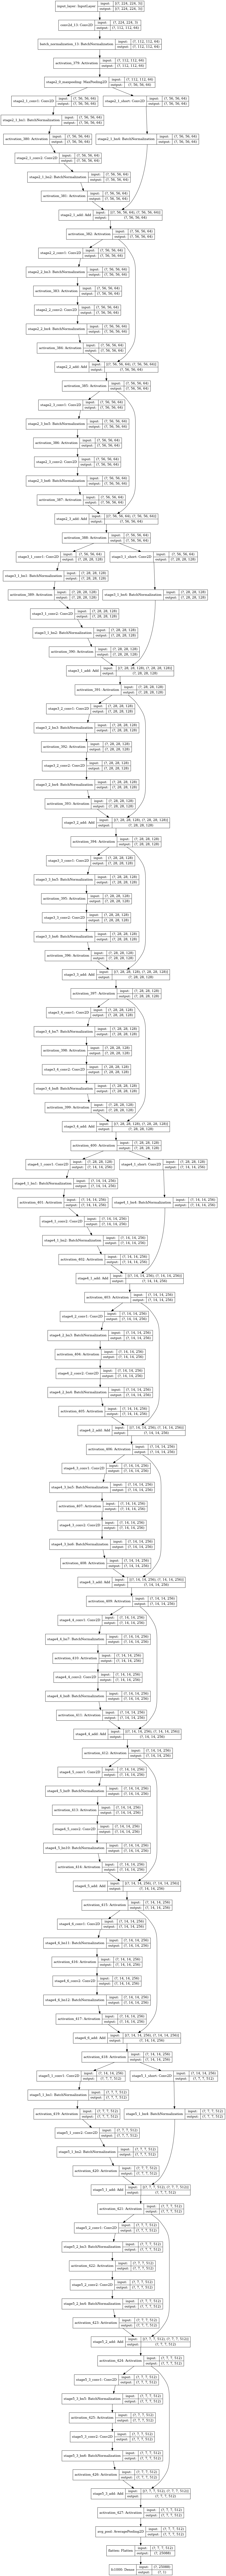

In [92]:
tf.keras.utils.plot_model(resnet_34, to_file='./resnet_34.png', show_shapes=True)

In [93]:
BATCH_SIZE = 8
EPOCH = 5

resnet_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001), 
    metrics=['accuracy'],
)

res_history_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_train_len/BATCH_SIZE),
    validation_steps=int(ds_test_len/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_valid,
    verbose=1,
)

Epoch 1/5
   2/2326 [..............................] - ETA: 2:49 - loss: 6.6440 - accuracy: 0.3750WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0360s vs `on_train_batch_end` time: 0.0588s). Check your callbacks.


2326/2326 [==============================] - 187s 80ms/step - loss: 1.2271 - accuracy: 0.5770 - val_loss: 0.7673 - val_accuracy: 0.5651
Epoch 2/5
2326/2326 [==============================] - 186s 80ms/step - loss: 0.6164 - accuracy: 0.6752 - val_loss: 0.8808 - val_accuracy: 0.6569
Epoch 3/5
2326/2326 [==============================] - 185s 80ms/step - loss: 0.5508 - accuracy: 0.7254 - val_loss: 1.1806 - val_accuracy: 0.5985
Epoch 4/5
2326/2326 [==============================] - 184s 79ms/step - loss: 0.5071 - accuracy: 0.7602 - val_loss: 6.6098 - val_accuracy: 0.4877
Epoch 5/5
2326/2326 [==============================] - 179s 77ms/step - loss: 0.4228 - accuracy: 0.8105 - val_loss: 0.4587 - val_accuracy: 0.7829


In [95]:
plain_34 = build_resnet(input_shape=INPUT_SHAPE,
    num_cnn_list=[3, 4, 6, 3],
    channel_list=[64, 128, 256, 512],
    num_classes=1,
    is_50=False,
    is_plain=True,)

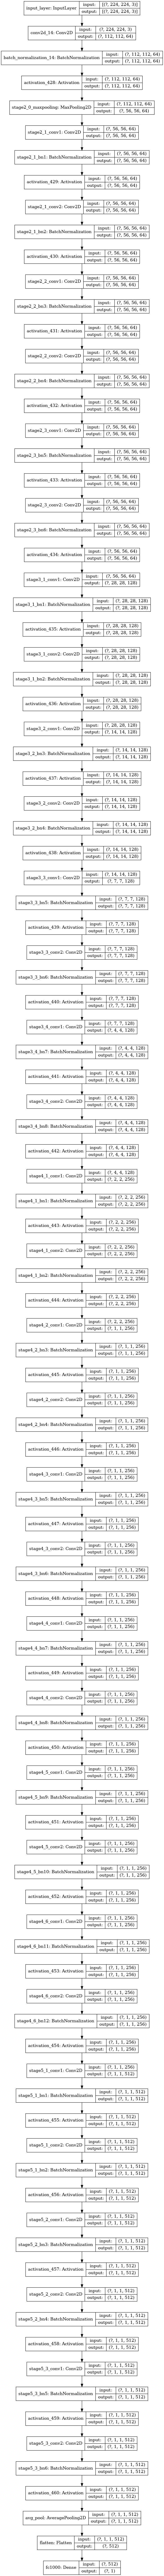

In [96]:
tf.keras.utils.plot_model(plain_34, to_file='./plain_34.png', show_shapes=True)

In [98]:
plain_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001), #, clipnorm=1.),
    metrics=['accuracy'],
)

pla_history_34 = plain_34.fit(
    ds_train,
    steps_per_epoch=int(ds_train_len/BATCH_SIZE),
    validation_steps=int(ds_test_len/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_valid,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/5
   2/2326 [..............................] - ETA: 1:44 - loss: 0.7048 - accuracy: 0.6250WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0225s vs `on_train_batch_end` time: 0.0342s). Check your callbacks.


2326/2326 [==============================] - 116s 50ms/step - loss: 0.6976 - accuracy: 0.5073 - val_loss: 0.6939 - val_accuracy: 0.5162
Epoch 2/5
2326/2326 [==============================] - 116s 50ms/step - loss: 0.6975 - accuracy: 0.5051 - val_loss: 0.6910 - val_accuracy: 0.4974
Epoch 3/5
2326/2326 [==============================] - 115s 50ms/step - loss: 0.6962 - accuracy: 0.5072 - val_loss: 0.6948 - val_accuracy: 0.4756
Epoch 4/5
2326/2326 [==============================] - 117s 50ms/step - loss: 0.6975 - accuracy: 0.4998 - val_loss: 0.6929 - val_accuracy: 0.5180
Epoch 5/5
2326/2326 [==============================] - 116s 50ms/step - loss: 0.6960 - accuracy: 0.5090 - val_loss: 0.7003 - val_accuracy: 0.4844


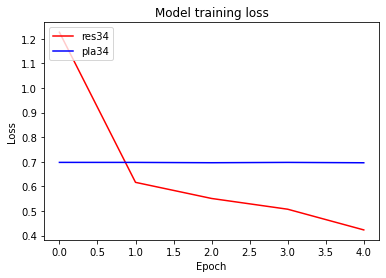

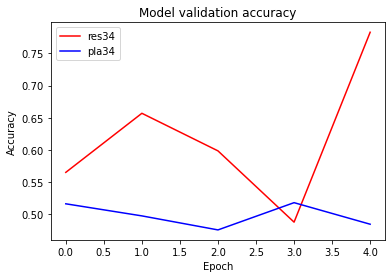

In [99]:
plot_loss_graph(res_history_34, pla_history_34, 34)
plot_acc_graph(res_history_34, pla_history_34, 34)

In [101]:
resnet_50 = build_resnet(input_shape=INPUT_SHAPE,
    num_cnn_list=[3, 4, 6, 3],
    channel_list=[64, 128, 256, 512],
    num_classes=1,
    is_50=True,
    is_plain=False,)

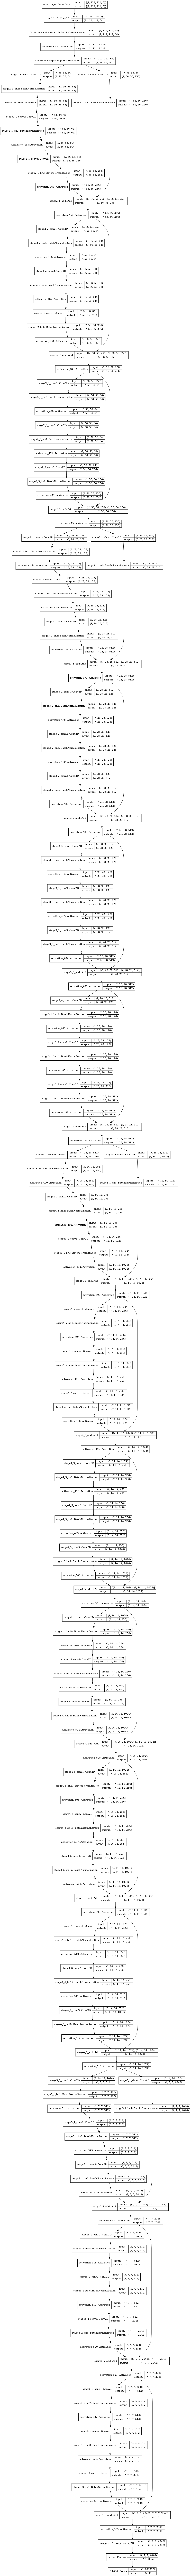

In [102]:
tf.keras.utils.plot_model(resnet_50, to_file='./resnet_50.png', show_shapes=True)

In [103]:
resnet_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001), 
    metrics=['accuracy'],
)

res_history_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_train_len/BATCH_SIZE),
    validation_steps=int(ds_test_len/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_valid,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/5
2326/2326 [==============================] - 345s 149ms/step - loss: 2.2022 - accuracy: 0.5396 - val_loss: 10.4725 - val_accuracy: 0.4950
Epoch 2/5
2326/2326 [==============================] - 318s 137ms/step - loss: 0.7577 - accuracy: 0.6486 - val_loss: 1.5272 - val_accuracy: 0.6533
Epoch 3/5
2326/2326 [==============================] - 311s 134ms/step - loss: 0.6348 - accuracy: 0.6793 - val_loss: 0.7218 - val_accuracy: 0.6227
Epoch 4/5
2326/2326 [==============================] - 308s 132ms/step - loss: 0.5448 - accuracy: 0.7362 - val_loss: 0.7439 - val_accuracy: 0.6726
Epoch 5/5
2326/2326 [==============================] - 310s 133ms/step - loss: 0.4725 - accuracy: 0.7874 - val_loss: 0.7278 - val_accuracy: 0.6905


In [105]:
plain_50 = build_resnet(input_shape=INPUT_SHAPE,
    num_cnn_list=[3, 4, 6, 3],
    channel_list=[64, 128, 256, 512],
    num_classes=1,
    is_50=True,
    is_plain=True,)

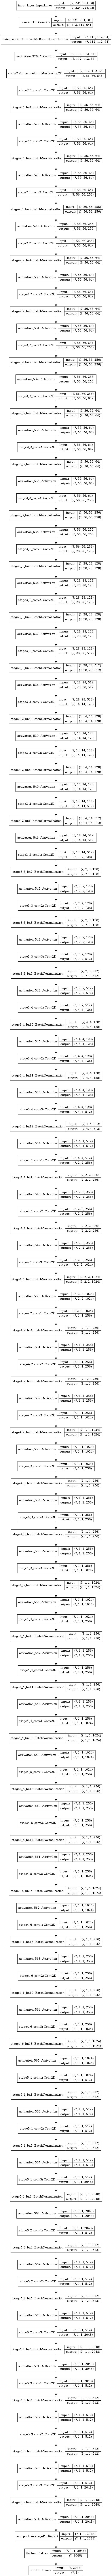

In [106]:
tf.keras.utils.plot_model(plain_50, to_file='./plain_50.png', show_shapes=True)

In [107]:
plain_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

pla_history_50 = plain_50.fit(
    ds_train,
    steps_per_epoch=int(ds_train_len/BATCH_SIZE),
    validation_steps=int(ds_test_len/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_valid,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/5
2326/2326 [==============================] - 180s 77ms/step - loss: 0.7372 - accuracy: 0.5070 - val_loss: 0.6913 - val_accuracy: 0.5063
Epoch 2/5
2326/2326 [==============================] - 149s 64ms/step - loss: 0.7182 - accuracy: 0.4985 - val_loss: 0.8778 - val_accuracy: 0.5242
Epoch 3/5
2326/2326 [==============================] - 148s 64ms/step - loss: 0.7165 - accuracy: 0.5004 - val_loss: 0.7217 - val_accuracy: 0.4784
Epoch 4/5
2326/2326 [==============================] - 149s 64ms/step - loss: 0.7114 - accuracy: 0.4977 - val_loss: 0.6929 - val_accuracy: 0.4838
Epoch 5/5
2326/2326 [==============================] - 149s 64ms/step - loss: 0.7051 - accuracy: 0.5164 - val_loss: 3.4665 - val_accuracy: 0.4760


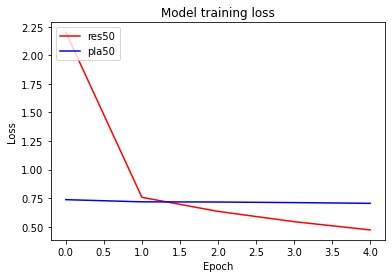

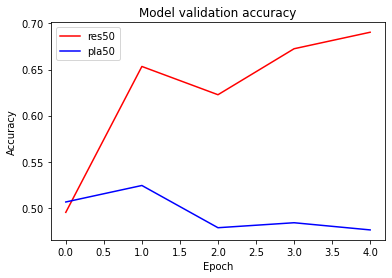

In [108]:
plot_loss_graph(res_history_50, pla_history_50, 50)
plot_acc_graph(res_history_50, pla_history_50, 50)

### 최종 결과

- VGG 모델은 노드를 따라가면서 쉽게 이해할 수 있었는데, ResNet은 난이도가 너무 높아서 따라가기 어려웠습니다. 
- 중간에 메모리 부족 에러가 자꾸 나서 BATCH SIZE는 8로 줄이고, EPOCH을 5로 대폭 줄여서 진행했습니다. 